# Portfolio Optimisation and Analysis

In this module I use portfolio optimisation techniques based on maximising Sharpe Ratio

I also construct an equally weighted portfolio based on the stocks identified in previous steps

Finally I perform a factor analysis based on 4 Fama French Factor Model that include:
- Size of the Company
- Value v Growth
- Opearting Profitability 
- Aggressiveness

I summarise performance using Quantstats package that computes sharpe ratio, drawdowns, ES, etc and compares to the market benchmark


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import quantstats as qs

from scipy.optimize import minimize

In [10]:
# Funcations to be used in Portfolio analysis

def drawdown(return_series: pd.Series):
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdowns
    })
def compound(r):
    return np.expm1(np.log1p(r).sum())

def target_met(weight, returns):
    return target_return - ptf_return(weight, returns)

def minimise_vol(target_return, returns, cov):
    from scipy.optimize import minimize
    n = returns.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    return_target = {"type": "eq", "args": (returns,), "fun": lambda weights, returns: target_return - ptf_return(weights, returns)}
    weights_sum = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
    results = minimize(ptf_vol, init_guess, args=(cov,), method = "SLSQP", options = {"disp":False},
                      constraints = (return_target, weights_sum), bounds=bounds)
    return results.x

def neg_sharpe(weights, riskfree, returns, cov):
    sharpe_return = ptf_return(weights, returns)
    sharpe_vol = ptf_vol(weights, cov)
    return - (sharpe_return- riskfree)/sharpe_vol

    
def max_sharpe(riskfree, returns, cov):
    from scipy.optimize import minimize
    n = returns.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    weights_sum = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
    results = minimize(neg_sharpe, init_guess, args=(riskfree, returns, cov,), method = "SLSQP", options = {"disp":False},
                      constraints = (weights_sum), bounds=bounds)
    return results.x


def optimal_weights(n_points, returns, cov):
    target_rets = np.linspace(returns.min(), returns.max(), n_points)
    weights = [minimise_vol(target_return, returns, cov) for target_return in target_rets]
    return weights

def efficient_frontier(n_points, returns, cov, show_best_ptf = False, show_ew=False, style = ".-", riskfree = 0):
    weights = optimal_weights(n_points, returns, cov)
    rets = [ptf_return(w, returns) for w in weights]
    vols = [ptf_vol(w, cov) for w in weights]
    ef = pd.DataFrame({"Returns" : rets, "Volatility" : vols})
    ax = ef.plot.line(x = "Volatility", y = "Returns", style=style)
    if show_ew == True:
        n = returns.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = ptf_return(w_ew, returns)
        vol_ew = ptf_vol(w_ew, cov)
        ax.plot([vol_ew], [r_ew], color = "green", marker = "o")
    if show_best_ptf == True:
        max_weights = max_sharpe(riskfree, annual_rets(stock_data_rets, 252), cov)
        max_returns = ptf_return(max_weights, annual_rets(stock_data_rets, 252))
        max_vol = ptf_vol(max_weights, cov)
        cml_x = [0, max_vol]
        cml_y = [riskfree, max_returns]
        ax.plot(cml_x, cml_y, linestyle = "dashed", marker = "o")
    return ax    
        
def annual_rets(returns, periods):
    comp_growth = (1+returns).prod()
    n_periods = returns.shape[0]
    return comp_growth**(periods/n_periods)-1

def annual_vol(returns, periods):
    return returns.std()*(periods**0.5)

def sharpe_ratio(returns, riskfree, periods):
    rf_per_period = (1+riskfree)**(1/periods)-1
    excess_ret = returns - rf_per_period
    ann_ex_ret = annual_rets(excess_ret, periods)
    ann_vol = annual_vol(returns, periods)
    return ann_ex_ret/ann_vol

def ptf_return(weights, returns):
    return weights.T @ returns

def ptf_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def backtest_ws(r, estimation_window=60, weighting=weight_ew, verbose=False, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert List of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

In [3]:
%store -r tickers_20

In [3]:
# Loading the tickers previously identified from our Fundamental and Sentiment Analysis

tickers_20 = ['ROST',
 'RJF',
 'BWA',
 'AMP',
 'AKAM',
 'EOG',
 'DFS',
 'APTV',
 'APH',
 'MET',
 'HES',
 'ACN',
 'UPS',
 'BR',
 'COP',
 'SEDG',
 'CSX',
 'IEX',
 'AME',
 'CTRA']

# Stock Prices are downloaded from Yahoo Finance
stock_data = yf.download(tickers_20, start="2021-01-01", end="2023-05-24")

[*********************100%***********************]  20 of 20 completed


<Axes: xlabel='Date'>

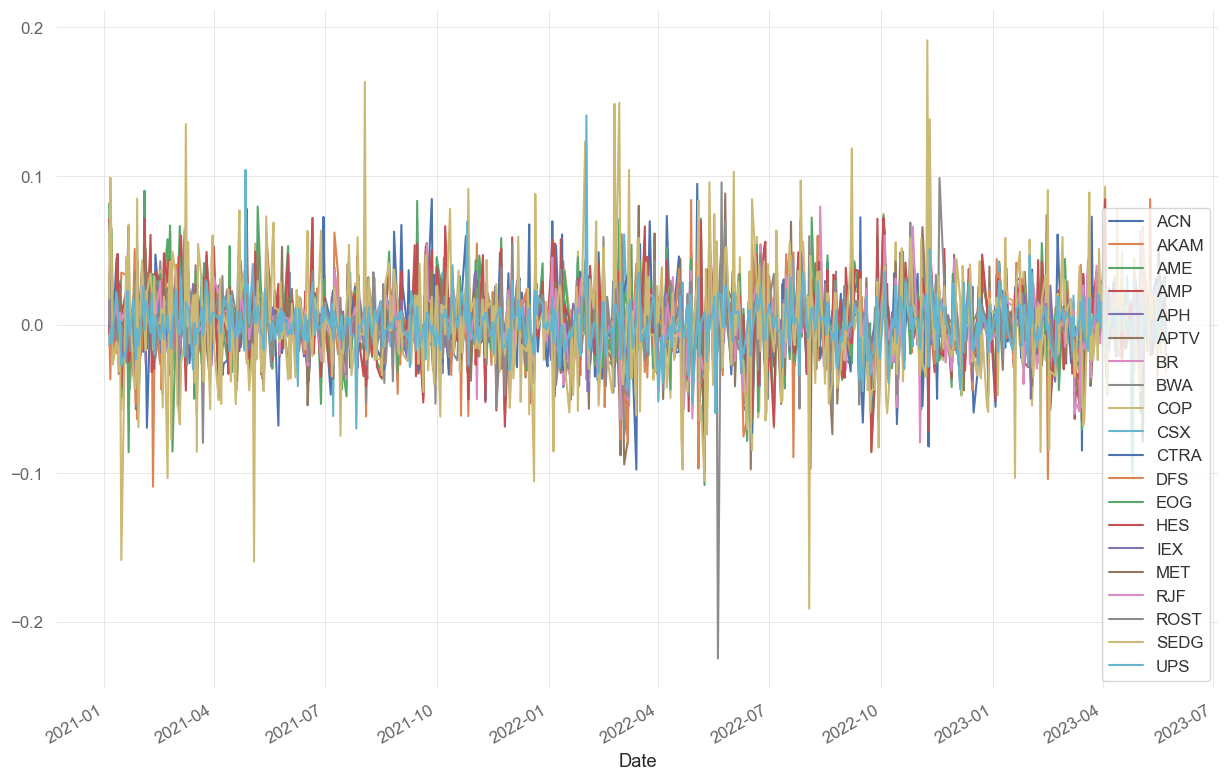

In [4]:
# Computing Stock Returns
stock_data_rets = stock_data["Close"].pct_change()
stock_data_rets.dropna(inplace = True)

# Plotting the stock Returns
stock_data_rets.plot(figsize = (15,10))

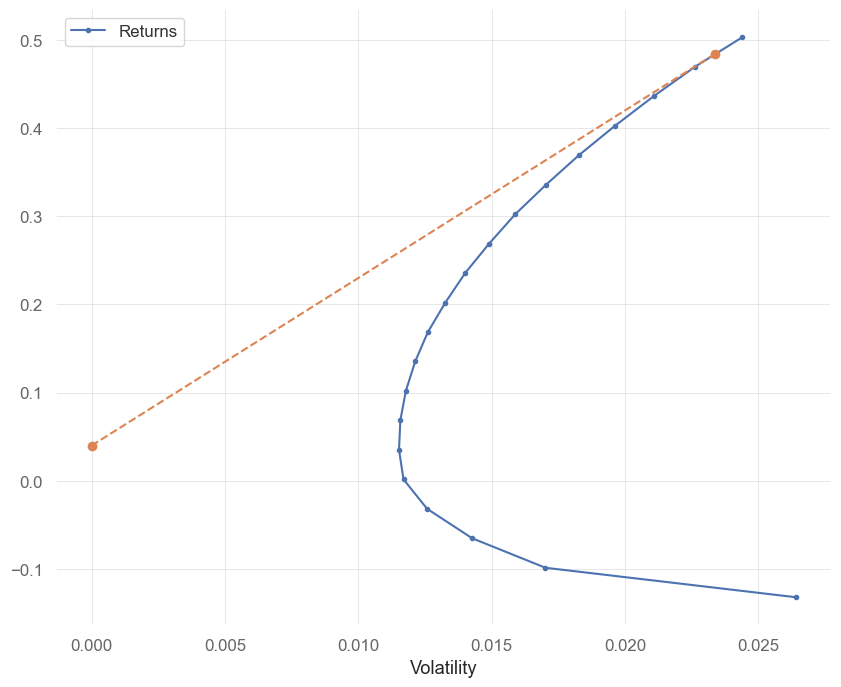

In [8]:
# Computing the covariance matrix between stocks
cov = stock_data_rets.cov()

# Calculating the weights for maximum Sharpe Ratio portfolio
max_weights = max_sharpe(0.04, annual_rets(stock_data_rets, 252), cov)
max_returns = ptf_return(max_weights, annual_rets(stock_data_rets, 252))
max_vol = ptf_vol(max_weights, cov)

plt.rcParams["figure.figsize"] = (10,8)

# Plotting the efficient frontier
ax = efficient_frontier(20, annual_rets(stock_data_rets, 252), cov)
cml_x = [0, max_vol]
cml_y = [0.04, max_returns]
ax.plot(cml_x, cml_y, linestyle = "dashed", marker = "o")

<Axes: xlabel='Volatility'>

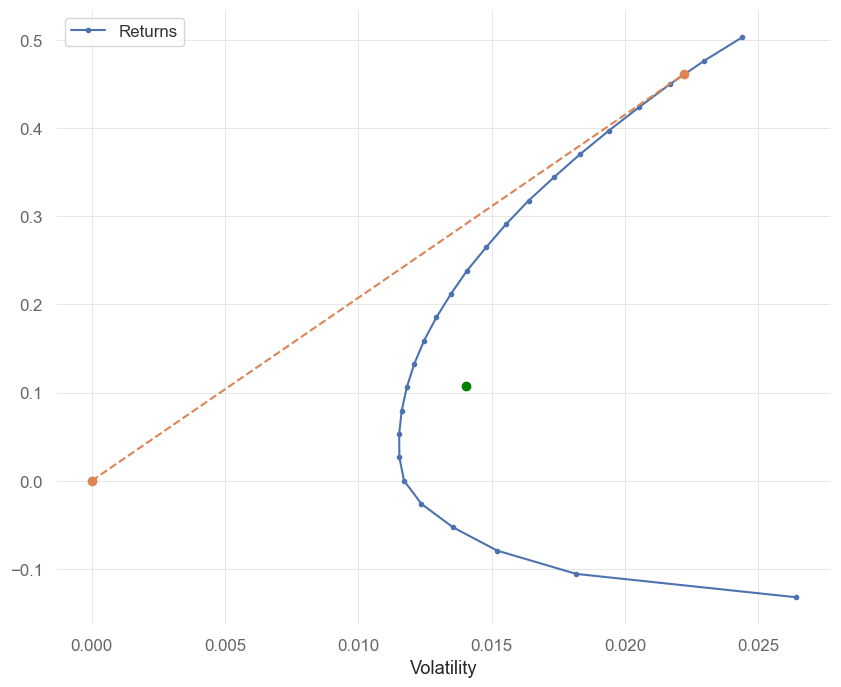

In [9]:
# Displaying the equally weighted portfolio on the efficient frontier 

efficient_frontier(25, annual_rets(stock_data_rets, 252), cov, show_best_ptf = True, show_ew=True, style = ".-", riskfree = 0)

In [12]:
# For our performance analysis and for Factor Analysis I convert daily stock data to monthly

rets_monthly = stock_data_rets.resample("M").apply(compound).to_period("M")

# Data for the Fama French factors was obtaiend from https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
fama_factors = pd.read_csv("FamaFactors.csv", header = 3)
fama_factors.rename(columns={ fama_factors.columns[0]: "Date" }, inplace = True)
fama_factors['Date'] = pd.to_datetime(fama_factors['Date'], format='%Y%m', errors='coerce')
fama_factors['Date'] = fama_factors['Date'].dt.strftime("%Y-%m")
fama_factors.dropna(inplace = True)
fama_factors.set_index(fama_factors['Date'] , inplace = True)
fama_factors.drop(columns=fama_factors.columns[0], axis=1, inplace=True)

# Converting from % to decimals
fama_factors["Mkt-RF"] = fama_factors["Mkt-RF"].astype(float)/100
fama_factors["SMB"] = fama_factors["SMB"].astype(float)/100
fama_factors["HML"] = fama_factors["HML"].astype(float)/100
fama_factors["RMW"] = fama_factors["RMW"].astype(float)/100
fama_factors["CMA"] = fama_factors["CMA"].astype(float)/100
fama_factors["RF"] = fama_factors["RF"].astype(float)/100

In [14]:
# Calculating excess returns and running an OLS regression to find our betas
rets_ew = backtest_ws(rets_monthly, estimation_window = 0)
df_rets_ptf = pd.DataFrame(rets_ew)
df_rets_ptf_excess = df_rets_ptf["2021-01":"2023-04"] - fama_factors.loc["2021-01":"2023-04", ["RF"]].values
mkt_excess = fama_factors.loc["2021-01":"2023-04", ["Mkt-RF"]]
mkt_excess["Value"] = fama_factors.loc["2021-01":"2023-04", ["HML"]]
mkt_excess["Size"] = fama_factors.loc["2021-01":"2023-04", ["SMB"]]
mkt_excess["CMA"] = fama_factors.loc["2021-01":"2023-04", ["CMA"]]
exp_var = mkt_excess.copy()
exp_var.index = df_rets_ptf_excess.index
exp_var["Constant"] = 1
lm = sm.OLS(df_rets_ptf_excess, exp_var).fit()

In [15]:
# OLS regression summary
# My Market Beta is 1.12
# Value beta is 0.51 = mostly invested into value stocks
# Size beta is 0.17 = more investment into bigger companies
# CMA is -0.10 = 


lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     73.49
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           9.23e-13
Time:                        13:24:29   Log-Likelihood:                 75.430
No. Observations:                  28   AIC:                            -140.9
Df Residuals:                      23   BIC:                            -134.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.1226      0.070     15.940      0.000       0.977       1.268
Value          0.5102      0.105      4.881      0.000       0.294       0.726
Size           0.1659      0.124      1.335      0.195      -0.091       0.423
CMA           -0.1032      0.148     -0.695      0.494      -0.410       0.204
Constant       0.0035      0.004      0.966      0.344      -0.004       0.011
==============================================================================
Omnibus:                        0.646   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.732
Skew:                          -0.275   Prob(JB):                        0.694
Kurtosis:                       2.429   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Creating a dataframe needed to calcualte performance

df_rets_ptf_ew = pd.DataFrame(rets_ew)
df_rets_ptf_ew.rename(columns={ df_rets_ptf_ew.columns[0]: "Ptf Returns" }, inplace = True)
df_rets_ptf_ew = df_rets_ptf_ew[:-1]
df_rets_ptf_ew["Ptf Ex Returns"] = df_rets_ptf_ew - fama_factors.loc["2021-01":"2023-04", ["RF"]].values
df_rets_ptf_ew.index = fama_factors["2021-01":"2023-04"].index
df_rets_ptf_ew["Cum PTF Rets"] = (df_rets_ptf_ew["Ptf Ex Returns"]+1).cumprod()
df_rets_ptf_ew = pd.concat([df_rets_ptf_ew, fama_factors.loc["2021-01":"2023-04", ["Mkt-RF"]]], axis = 1)
df_rets_ptf_ew["Cum MKT Rets"] = (df_rets_ptf_ew["Mkt-RF"]+1).cumprod()      

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2021-01-01  2021-01-01
End Period          2023-04-01  2023-04-01
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   32.11%      4.19%
CAGR﹪              13.2%       1.84%

Sharpe              3.03        0.85
Sortino             5.16        1.2
Sortino/√2          3.65        0.85
Omega               1.67        1.67

Max Drawdown        -14.39%     -25.45%
Longest DD Days     214         455

Gain/Pain Ratio     0.67        0.14
Gain/Pain (1M)      0.67        0.14

Payoff Ratio        1.3         0.87
Profit Factor       1.67        1.14
Common Sense Ratio  1.96        0.94
CPC Index           1.16        0.57
Tail Ratio          1.17        0.82
Outlier Win Ratio   2.09        2.94
Outlier Loss Ratio  2.71        2.25

MTD                 -1.01%      0.61%
3M                  -1.82%      7.16%
6M                  12.01%      13.11%


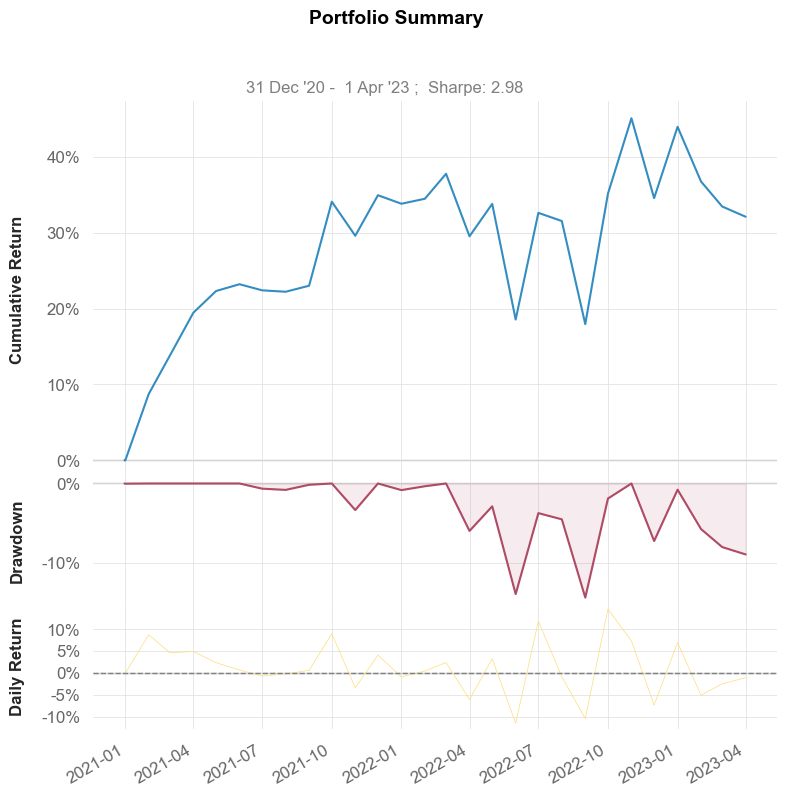

C:\Users\user\anaconda3\lib\site-packages\quantstats\stats.py:906: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


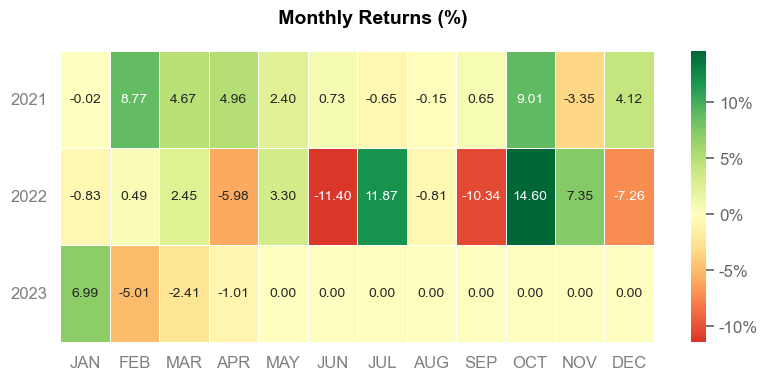

In [181]:
# Running the Quantstats packcage to analyse performance

df_rets_ptf_ew.index = pd.to_datetime(df_rets_ptf_ew.index)
qs.reports.basic(df_rets_ptf_ew["Ptf Ex Returns"], df_rets_ptf_ew["Mkt-RF"])